**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [8]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)

Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import mode
from sklearn.neighbors import KDTree


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors=2, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.classes = None
        self.fit_X = None
        self.y = None
        self.tree = None
        pass

    def fit(self, X, y):
        self.fit_X = X
        y = y.reshape((-1, 1))
        self.y = np.empty(y.shape, dtype=np.int)
        self.classes, self.y[:, 0] = np.unique(y, return_inverse=True)

        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=30)

    def my_kneighbors(self, X):
        if self.algorithm == 'brute':
            pairwise_dist = pairwise_distances(X, self.fit_X,
                                               metric=self.metric)
            neigh_ind = np.argpartition(
                pairwise_dist, self.n_neighbors)[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            _, neigh_ind = self.tree.query(X, k=self.n_neighbors)
            neigh_ind = np.array(neigh_ind)
        else:
            raise ValueError('bad algorithm')
        return neigh_ind

    def predict(self, X):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        y_pred = np.empty((n_samples, 1), dtype=self.classes.dtype)
        neigh_ind = self.my_kneighbors(X)
        mod, _ = mode(self.y[neigh_ind, 0], axis=1)
        y_pred[:, 0] = self.classes.take(mod.ravel())
        return y_pred.ravel()

    def predict_proba(self, X):
        n_samples = X.shape[0]
        neigh_ind = self.my_kneighbors(X)
        pred_labels = self.y[:, 0][neigh_ind]
        all_rows = np.arange(X.shape[0])
        proba_ = np.zeros((n_samples, self.classes.size))
        for i, idx in enumerate(pred_labels.T):
            proba_[all_rows, idx] += 1

        normalizer = proba_.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba_ /= normalizer
        return proba_

    def score(self, X, y):
        return self.my_accuracy_score(y, self.predict(X))

    def my_accuracy_score(self, y_true, y_pred):
        score = y_true == y_pred
        result = np.average(score)
        return result

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [12]:
iris = datasets.load_iris()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [15]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [16]:
y_pred_my = my_clf.predict(X_test)
y_pred = clf.predict(X_test)

In [17]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [18]:
%time clf.fit(X_train, y_train)

CPU times: user 902 µs, sys: 147 µs, total: 1.05 ms
Wall time: 947 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [19]:
%time my_clf.fit(X_train, y_train)

CPU times: user 171 µs, sys: 58 µs, total: 229 µs
Wall time: 195 µs


In [20]:
%time clf.predict(X_test)

CPU times: user 3.05 ms, sys: 1.51 ms, total: 4.56 ms
Wall time: 3.81 ms


array([0, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0])

In [21]:
%time my_clf.predict(X_test)

CPU times: user 1.89 ms, sys: 69 µs, total: 1.96 ms
Wall time: 1.94 ms


array([0, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0])

In [22]:
%time clf.predict_proba(X_test)

CPU times: user 679 µs, sys: 13 µs, total: 692 µs
Wall time: 698 µs


array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ]])

In [23]:
%time my_clf.predict_proba(X_test)

CPU times: user 440 µs, sys: 0 ns, total: 440 µs
Wall time: 445 µs


array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [24]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [26]:
%time clf.fit(X_train, y_train)

CPU times: user 1.6 ms, sys: 2.36 ms, total: 3.95 ms
Wall time: 3.77 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [27]:
%time my_clf.fit(X_train, y_train)

CPU times: user 608 µs, sys: 138 µs, total: 746 µs
Wall time: 663 µs


In [28]:
%time clf.predict(X_test)

CPU times: user 2.95 ms, sys: 712 µs, total: 3.66 ms
Wall time: 3.03 ms


array([1, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 2])

In [29]:
%time my_clf.predict(X_test)

CPU times: user 1.77 ms, sys: 577 µs, total: 2.35 ms
Wall time: 1.8 ms


array([1, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 2])

In [30]:
%time clf.predict_proba(X_test)

CPU times: user 1.59 ms, sys: 211 µs, total: 1.8 ms
Wall time: 1.65 ms


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [31]:
%time my_clf.predict_proba(X_test)

CPU times: user 700 µs, sys: 154 µs, total: 854 µs
Wall time: 745 µs


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [32]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [33]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [34]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [35]:
import re
data_tok = [re.sub('[^\w]', ' ', d).lower().split() for d in data]
data_tok, target = map(list, zip(*[(v,k) for v,k in zip(data_tok, target) if v != []]))
target = np.array(target)
# data_tok should be a list of lists of tokens for each line in data.

In [36]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [37]:
from scipy.sparse import csr_matrix

indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
ar = csr_matrix((data, indices, indptr), dtype=int)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [38]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=3, random_state=0, test_size=0.1)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [39]:
def best_n_neighbors(X, Y, **kwargs):
    n_best = 1
    ac_best = 0
    x = []
    y = []
    for n_neighbors in range(1, 11):
        clf = MyKNeighborsClassifier(n_neighbors=n_neighbors,
                                     algorithm='brute', **kwargs)
        scores = cross_validate(clf, X, Y, scoring=['accuracy'], cv=rs)
        ac = scores['test_accuracy'].mean()
        x.append(n_neighbors)
        y.append(ac)
        if ac > ac_best:
            n_best = n_neighbors
            ac_best = ac
    print('n_best = ', n_best)
    print('ac_best =', ac_best)
    return n_best, x, y

n_best =  1
ac_best = 0.23735997577959433


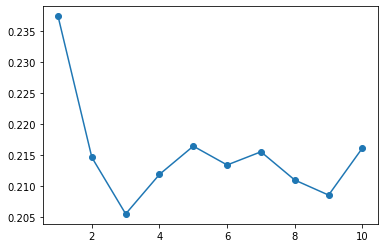

In [40]:
%matplotlib inline
n_best, x, y = best_n_neighbors(ar, target, metric='euclidean')
plt.plot(x, y, 'o-')


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

n_best =  1
ac_best = 0.31244323342415986


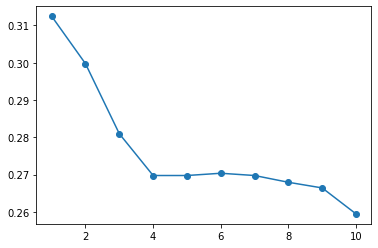

In [32]:
n_best, x, y = best_n_neighbors(ar, target, metric='cosine')
plt.plot(x, y, 'o-')
# косинусная лучше

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
tr = TfidfTransformer()
tr.fit(ar)
arr = tr.transform(ar)
print(arr.shape)

(11004, 101675)


n_best =  9
ac_best = 0.6551619739630639
9


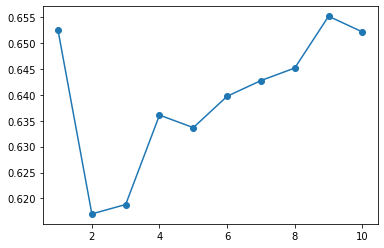

In [34]:
n_best, x, y = best_n_neighbors(arr, target, metric='cosine')
print(n_best)
plt.plot(x, y, 'o-')
# после tf-idf еще лучше

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [35]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [36]:
data_test = newsgroups['data']
target_test = newsgroups['target']

data_tok_test = [re.sub('[^\w]', ' ', d).lower().split() for d in data_test]
data_tok_test, target_test = \
    map(list, zip(*[(v, k) for v, k in zip(data_tok_test, target_test)
                    if v != []]))
target_test = np.array(target_test)

indptr = [0]
indices = []
data = []
for d in data_tok_test:
    for term in d:
        index = vocabulary.get(term)
        if not index:
            continue
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

ar_test = csr_matrix((data, indices, indptr), dtype=int,
                     shape=(len(data_tok_test), len(vocabulary)))
tr = TfidfTransformer()
tr.fit(ar_test)
arr_test = tr.transform(ar_test)


Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [37]:
clf = MyKNeighborsClassifier(algorithm='brute', n_neighbors=n_best)
clf.fit(ar, target)
sc = clf.score(ar_test, target_test)
scores = cross_validate(clf, arr, target, scoring=['accuracy'], cv=rs)
print('cv_accuracy = ', scores['test_accuracy'].mean())
print('test_accuracy = ', sc)
# плохо на тесте, неверное много новых слов в тестовой выборке

cv_accuracy =  0.6551619739630639
test_accuracy =  0.16855931043918457
